In this notebook we model the resonance equivalent circuit, shown below

![equivalen_circuit](res_equivalentCircuit.PNG)

Import useful libraries

In [1]:
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

Define simulation parameters

In [2]:
Sim_period = 100000
Sim_fs   = 10

Sim_dt = 1/Sim_fs
Sim_t = np.arange(0,Sim_period,Sim_dt)

Membrane parameters initialization

In [ ]:
g_leak = .1
g_Na = .001
g_L = 100
L = 2.5  # mH  -> since the simulation is in ms, then we need the time constants to be in 
C = 100  # kF
V_leak = 0
V_Na = 300

tau_L = g_L * L
print(tau_L, 1000 * 1/(2*np.pi*np.sqrt(L*C)))

I_stim = 1

# non-linearity
k = 1
V_half = 1
Vm_range = np.ceil(5 - (-5))

Let's see the impedance of these parameters

In [ ]:
f = np.arange(0,1,.00001)  # kHz
w = 2 * np.pi * f

R_L = 1 / g_L
R_leak = 1 / g_leak

z = (g_leak + 1j*w*C + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

plt.loglog(f * 1000, z_amp)
plt.show()

### Parameter set 1

In [3]:
g_leak = 1 / (56.7e3)
g_Na = 1 / (100)
g_L =   1 / (46.1e1) # decrease the power of 10 for this and C to scale the impedance (does not change fres)
L = 126 * 1e3
C = 100e-2 * 1e-3
V_leak = 0
V_Na = 0

tau_L = g_L * L
print('inductor time constant:', tau_L, 'ms')
print('resonance frequency:', 1000 * 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

I_stim = 200e-9

# non-linearity
k = 1
V_half = 0
Vm_range = np.ceil(2 - (-2))

inductor time constant: 273.3188720173536 ms
resonance frequency: 14.178649249080394 Hz


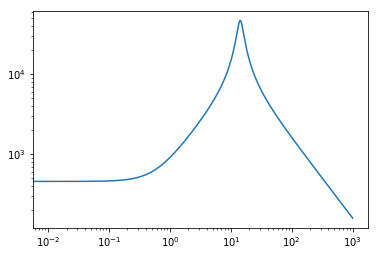

In [4]:
f = np.arange(0,1,.00001)  # kHz
w = 2 * np.pi * f

R_L = 1 / g_L
R_leak = 1 / g_leak

z = (g_leak + 1j*w*C + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)


plt.loglog(f * 1000, z_amp)
plt.show()

### Parameter set 2

In [ ]:
g_leak = 1 / (56.7e8)
g_Na = .01
g_L = 1 / (80e5)
L = 1.26
C = 3.1e-7
V_leak = 0
V_Na = 0

tau_L = g_L * L
print('inductor time constant:', tau_L, 'ms')
print('resonance frequency:', 1000 * 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

I_stim = 200e-9

### Parameter set 3

In [ ]:
g_leak = 1 / (56.7e8)
g_Na = .01
g_L = 1 / (80e3)
L = 1.26
C = 3.1e-5
V_leak = 0
V_Na = 0

tau_L = g_L * L
print('inductor time constant:', tau_L, 'ms')
print('resonance frequency:', 1000 * 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

I_stim = 200e-9

### Parameter set 4

In [ ]:
g_leak = 1 / (56.7e6)
g_Na = .01
g_L = 1 / (46.1e6)
L = 1.26
C = 3.1e-11
V_leak = 0
V_Na = 0

tau_L = g_L * L
print('inductor time constant:', tau_L, 'ms')
print('resonance frequency:', 1000 * 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

I_stim = 200e-9

## Non-linearity

In [ ]:
I_stim = 1
k = 1
Vm = np.arange(-1,1,.0001)

Vm_range = np.ceil(Vm.max() - Vm.min())
V_half = 0

print(Vm_range)
Boltzman_nl = k / (1 + np.exp(20/Vm_range*(V_half - Vm)))

plt.plot(Vm, Boltzman_nl**3)
plt.show()

## Start the simulation

In [5]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
Boltzman_nl = np.zeros(Vm.shape)

stimulation

In [6]:
I = I_stim * np.ones(Sim_t.shape)  # pA

I1 = fn.gen_sin(init_time=0,
                freq=.01,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=0.011,
                phase=-0,
                time_points=Sim_t)

I = I1

# Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=.00000001, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=.02, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I      = I_stim * out  # pA

In [9]:
for i in range(I.shape[0]-1):
    
    # Boltzmann non-linearity
    Boltzman_nl[i] = k / (1 + np.exp(20/Vm_range*(V_half - Vm[i])))
#     Boltzman_nl[i] = 0
    
    # current through the leak branch
    I_leak = g_leak*(Vm[i]-V_leak)
    
    # current through the membrane capacitance
    I_Na = g_Na*(Boltzman_nl[i]**3)*(Vm[i]-V_Na)
    
    # current through the inductor
    I_L_ss = Vm[i] * g_L
    dILdt = (I_L_ss - I_L[i]) / tau_L
    I_L[i+1] = I_L[i] + dILdt * Sim_dt
    
    dVmdt = (I[i] - I_leak - I_Na - I_L[i]) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

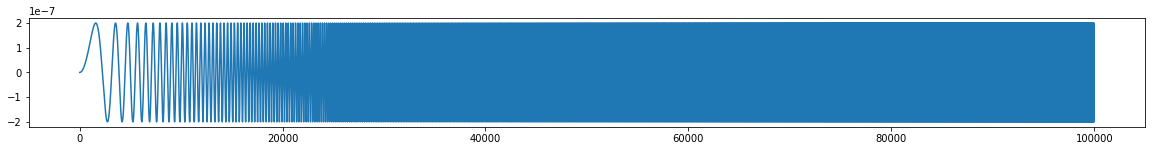

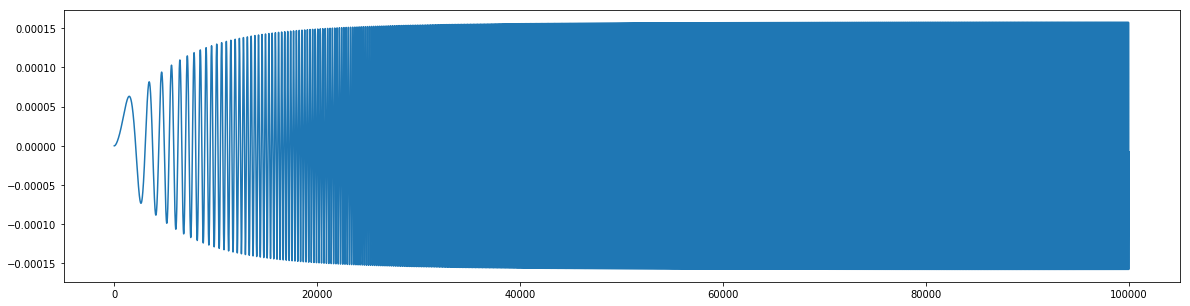

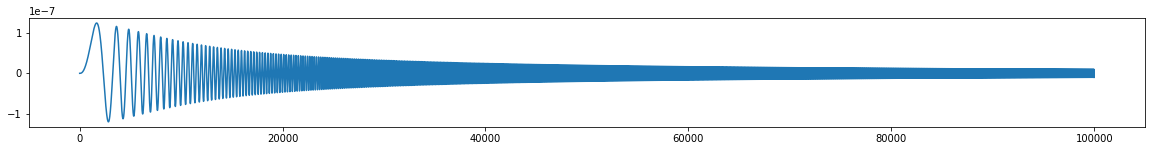

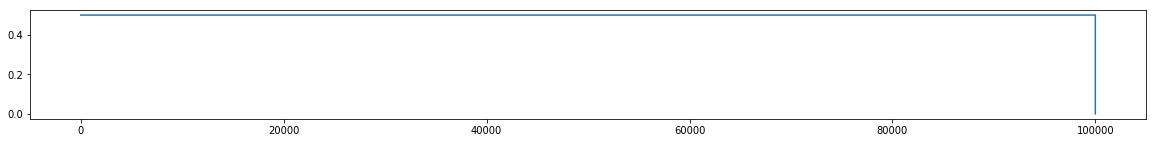

In [10]:
plt.figure(figsize=(20,2))
plt.plot(Sim_t, I)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Sim_t, Vm)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, I_L)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, Boltzman_nl)
plt.show()